In [1]:
import json
import pandas  as pd
import geopandas as gpd
from shapely.geometry import MultiLineString
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
from scipy.spatial import distance
from pykrige.ok import OrdinaryKriging
import cartopy.crs as ccrs
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import griddata

In [2]:
with open("D:\dev\openCV\intensity_data.json") as read_file:
    intensity_data = json.load(read_file)

print(type(intensity_data))

<class 'dict'>


In [3]:
features = intensity_data["features"]

geometries = []
values = []
colors = []
weights = []

for feature in features:
    coordinates = feature['geometry']['coordinates']
    properties = feature['properties']

    multiline = MultiLineString(coordinates)
    geometries.append(multiline)

    values.append(properties['value'])
    colors.append(properties['color'])
    weights.append(properties['weight'])

In [4]:
gdf = gpd.GeoDataFrame({
    'geometry' : geometries,
    'value' : values,
    'color' : colors,
    'weight' : weights
    },
    crs="EPSG:4326"   
)

In [6]:
gdf.head()

,geometry,value,color,weight
0,"MULTILINESTRING ((89.65848 31.95, 89.66605 31....",3.0,#a0e5ff,2
1,"MULTILINESTRING ((80.85 29.4914, 80.88591 29.5...",3.5,#90f2ff,4
2,"MULTILINESTRING ((80.85 26.97175, 80.89991 26....",4.0,#80ffff,2
3,"MULTILINESTRING ((85.29202 25.26354, 85.05911 ...",4.5,#7cffc7,4
4,"MULTILINESTRING ((85.12566 25.57628, 85.05911 ...",5.0,#7cff90,2


In [5]:
mun_lat_lon = pd.read_csv("D:\dev\openCV\mun_lattitude.csv")
mun_lat_lon.head()

mun_lat_lon.rename(columns={'Unnamed: 0': 'Municipality'}, inplace=True)

mun_lat_lon.head()

,Municipality,lat,lng
0,Champadevi Rural Municipality,27.279530,86.267141
1,Chishankhu Gadhi Rural Municipality,26.589858,87.214524
2,Khiji Demba Rural Municipality,27.458782,86.360098
3,Likhu Rural Municipality,27.866070,85.401439
4,Manebhanjyang Rural Municipality,27.169869,86.430035


In [5]:
ward_lat_lon = pd.read_csv("D:\dev\openCV\ward_id_and_lat_lon_mapping.csv")
ward_lat_lon.head()

,ward_id,latitude,longitude
0,120101,27.275716,86.275134
1,120102,27.261992,86.235941
2,120103,27.300831,86.275827
3,120104,27.310806,86.345178
4,120105,27.293568,86.327860


In [6]:
def extract_points_from_multistring(geometry):
    points = []
    if geometry.geom_type == 'MultiLineString':
        for line in geometry.geoms:
            points.extend(list(line.coords))
    return points

all_points = []
all_values = []

for idx, row in gdf.iterrows():
    contour_points = extract_points_from_multistring(row['geometry'])
    all_points.extend(contour_points)
    all_values.extend([row['value']]*len(contour_points))

all_lat = []
all_lng = []
for lat_lon in all_points:
    all_lat.append(lat_lon[1])
    all_lng.append(lat_lon[0])

In [7]:
df_eq = pd.DataFrame([all_lat,all_lng,all_values]).transpose()
df_eq.columns = ["latitude","longitude","intensity"]
df_eq.head()

,latitude,longitude,intensity
0,31.950000,89.658480,3.0
1,31.866841,89.666054,3.0
2,31.847690,89.684140,3.0
3,31.820714,89.783961,3.0
4,31.683890,89.890925,3.0


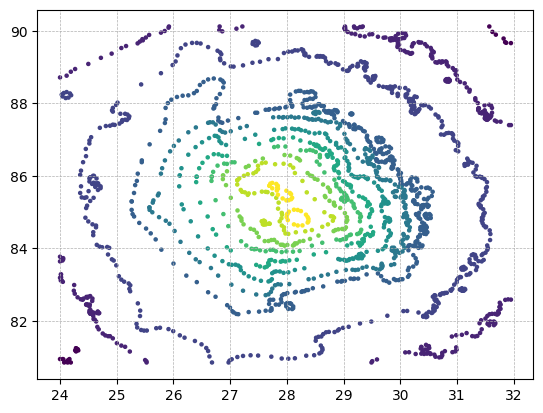

In [8]:
plt.scatter(df_eq["latitude"], df_eq["longitude"], c=df_eq["intensity"], s=5)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

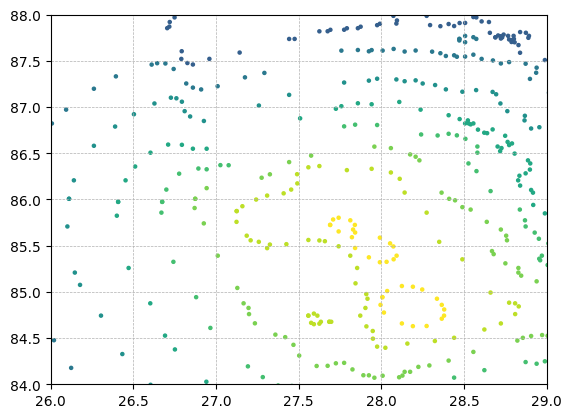

In [30]:
plt.scatter(df_eq["latitude"], df_eq["longitude"], c=df_eq["intensity"], s=5)

plt.xlim(26, 29)
plt.ylim(84, 88)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

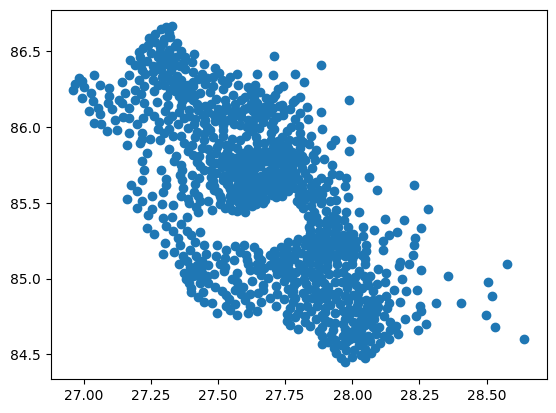

In [9]:
plt.scatter(ward_lat_lon["latitude"],ward_lat_lon["longitude"])

In [11]:
latitudes = np.array(df_eq['latitude'])
longitudes = np.array(df_eq['longitude'])
intensities = np.array(df_eq['intensity'])

new_latitudes = np.array(ward_lat_lon['latitude'])
new_longitudes = np.array(ward_lat_lon['longitude'])

new_points = np.column_stack((new_latitudes,new_longitudes))

existing_points = np.column_stack((latitudes,longitudes))



In [12]:
interpolated_intensities = griddata(existing_points,intensities,new_points,method='linear')

ward_lat_lon["pred_intensity"] = interpolated_intensities

ward_lat_lon.head()


,ward_id,latitude,longitude,pred_intensity
0,120101,27.275716,86.275134,6.928824
1,120102,27.261992,86.235941,6.986425
2,120103,27.300831,86.275827,6.960487
3,120104,27.310806,86.345178,6.881559
4,120105,27.293568,86.327860,6.878566


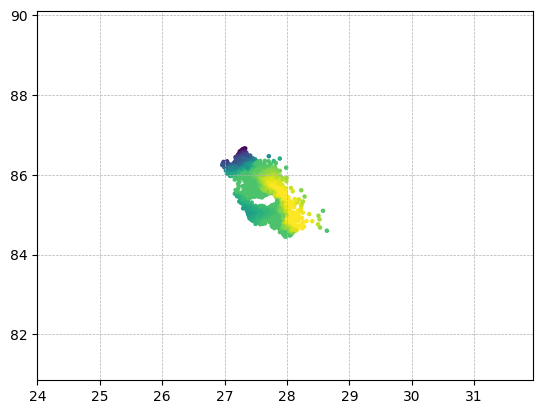

In [14]:

plt.scatter(ward_lat_lon["latitude"], ward_lat_lon["longitude"], c=ward_lat_lon["pred_intensity"], s=5)
plt.xlim(min(latitudes), max(latitudes))
plt.ylim(min(longitudes), max(longitudes))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

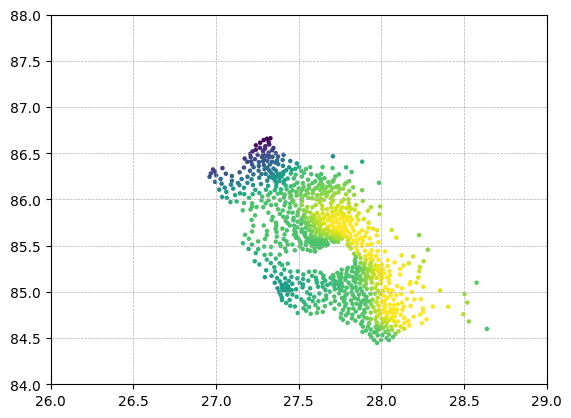

In [16]:
plt.scatter(ward_lat_lon["latitude"], ward_lat_lon["longitude"], c=ward_lat_lon["pred_intensity"], s=5)
plt.xlim(26, 29)
plt.ylim(84, 88)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


In [18]:
ward_lat_lon.to_csv("ward_level_pred_intensity.csv",index=False)